In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
nltk.download('punkt')

import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import TensorDataset, Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 676729.86it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 77928.16it/s]


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 500x800 with 0 Axes>

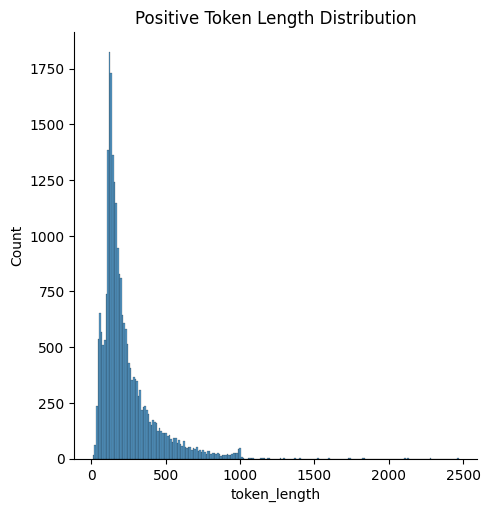

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

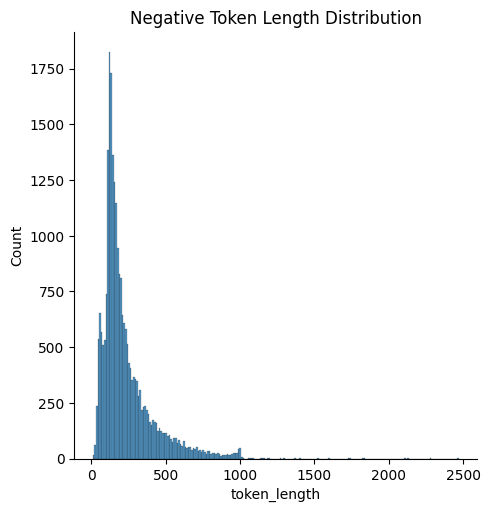

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [ ]:
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


# clean and preprocess

In [ ]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)         # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected


In [ ]:
# Tokenize, Remove stopwords, Lemmatization

def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [01:46<00:00, 468.65it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transformer/imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

# prepare dataset

In [ ]:
reviews = data['processed'].values
# 개별 텍스트 문자열을 공백으로 구분하여 결합
words = ' '.join(reviews)
words = words.split()

words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [ ]:
# build vocabulary

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'        # <PAD>에 인덱스 0을 할당
word2int = {word: id for id, word in int2word.items()}

In [ ]:
# encode words - 각 토큰을 해당 어휘의 인덱스로 변환

reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 50000/50000 [00:01<00:00, 29168.36it/s]

[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


In [ ]:
# padding and trimming - 모든 입력 시퀀스가 동일한 길이 (256)를 갖도록 함

def pad_features(reviews, pad_token, seq_length=128):
    # pad_token 값으로 채움
    features = np.full((len(reviews), seq_length), pad_token, dtype=int)

    for i, row in enumerate(reviews):
        # 행을 원하는 길이로 잘라 seq_length에 맞도록 함
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_token=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [ ]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return torch.tensor(x), torch.tensor(y)


In [ ]:
train_size = 0.7
val_size = 0.5
batch_size = 128

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [ ]:
batch_size = 128

trainset = IMDbDataset(train_x, train_y)
validset = IMDbDataset(val_x, val_y)
testset = IMDbDataset(test_x, test_y)

train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(validset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(testset, shuffle=False, batch_size=batch_size)

In [ ]:
x, y = next(iter(train_loader))

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[29743, 19227, 54857,  ...,     0,     0,     0],
        [ 1507,   281,  8578,  ...,     0,     0,     0],
        [   14,     5,   343,  ...,     0,     0,     0],
        ...,
        [ 1136,   244,  1863,  ...,     0,     0,     0],
        [  764,    52,    34,  ...,     0,     0,     0],
        [   11,   174,   184,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# modeling

In [ ]:
vocab_size = len(word2int) +1
hidden_size = 768
embedding_size = 64
batch_size = 128
n_heads = 8
n_layers = 6
n_labels = 2
dropout = .15
learning_rate = 1e-4

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.15, max_len=256):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerNet(nn.Module):
  def __init__(self, num_vocab, embedding_dim, hidden_size, n_heads, n_layers, max_len, num_labels, dropout):
    super(TransformerNet, self).__init__()

    self.embedding = nn.Embedding(num_vocab, embedding_dim)

    self.pe = PositionalEncoding(embedding_dim, max_len = max_len)

    enc_layer = nn.TransformerEncoderLayer(embedding_dim, n_heads, hidden_size, dropout)
    self.encoder = nn.TransformerEncoder(enc_layer, num_layers = n_layers)

    self.dense = nn.Linear(embedding_dim, num_labels)
    self.log_softmax = nn.LogSoftmax()

  def forward(self, x):
    x = self.embedding(x).permute(1, 0, 2)
    x = self.pe(x)
    x = self.encoder(x)
    x = x.mean(dim=0)
    x = self.dense(x)
    return x


In [ ]:
model = TransformerNet(vocab_size, embedding_size, hidden_size, n_heads, n_layers, seq_length , n_labels, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

TransformerNet(
  (embedding): Embedding(121302, 64)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=768, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=768, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (dropout2): Dropout(p=0.15, inplace=False)
      )
    )
  )
  (dense): Linear(in_features=64, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)

# training

In [ ]:
# training config

grad_clip = 5
print_every = 1
epochs = 8
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    train_acc, total, train_loss = 0, 0, 0

    for id, (feature, target) in enumerate(train_loader):
        feature, target = feature.cuda(), target.cuda()

        optimizer.zero_grad()

        out = model(feature)

        predicted = torch.argmax(out, dim=1)
        target = target.cuda()
        correct = predicted.squeeze() == target.int()
        train_acc += correct.sum().item()

        total += correct.size(0)
        loss = criterion(out, target.cuda())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        del feature, target

        if id % 50 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(e,
                                                                           id * len(x),
                                                                           len(train_loader),
                                                                           100. * id / len(train_loader),
                                                                           loss.item()))
    avg_loss = train_loss / len(train_loader)
    avg_accuracy = train_acc / total

    return avg_loss, avg_accuracy

In [ ]:
def evaluate(model, val_loader):
    val_acc, total, val_loss = 0, 0, 0

    with torch.no_grad():
      for id, (feature, target) in enumerate(val_loader):
          feature, target = feature.cuda(), target.cuda()

          out = model(feature)

          predicted = torch.argmax(out, dim=1)
          correct = predicted.squeeze() == target.int()
          val_acc += correct.sum().item()

          total += correct.size(0)
          loss = criterion(out, target.cuda())
          val_loss += loss.item()
          del feature, target, predicted

    avg_loss = val_loss / len(val_loader)
    avg_accuracy = val_acc / total

    return avg_loss, avg_accuracy

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

val_loss_min = torch.inf
es_trigger = 0
es_threshold = 3
epochs = 8

for e in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    print("[EPOCH: %d], Train Loss: %5.2f | Train Accuracy: %5.2f%%" % (e, train_loss, train_accuracy * 100))
    print("[EPOCH: %d], Val Loss: %5.2f | Val Accuracy: %5.2f%%" % (e, val_loss, val_accuracy * 100))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < val_loss_min:
       val_loss_min = val_loss
       torch.save(model.state_dict(), './sentiment_lstm.pt')
       es_trigger = 0
    else:
       es_trigger += 1

    if es_trigger >= es_threshold:
        print("Early stopping triggered!")
        break

Train Epoch: 1 [0/274 (0%)]	Loss: 0.773867
Train Epoch: 1 [6400/274 (18%)]	Loss: 0.697155
Train Epoch: 1 [12800/274 (36%)]	Loss: 0.694218
Train Epoch: 1 [19200/274 (55%)]	Loss: 0.694269
Train Epoch: 1 [25600/274 (73%)]	Loss: 0.693471
Train Epoch: 1 [32000/274 (91%)]	Loss: 0.691171
[EPOCH: 1], Train Loss:  0.70 | Train Accuracy: 50.21%
[EPOCH: 1], Val Loss:  0.69 | Val Accuracy: 51.19%
Train Epoch: 2 [0/274 (0%)]	Loss: 0.694781
Train Epoch: 2 [6400/274 (18%)]	Loss: 0.690785
Train Epoch: 2 [12800/274 (36%)]	Loss: 0.691669
Train Epoch: 2 [19200/274 (55%)]	Loss: 0.690263
Train Epoch: 2 [25600/274 (73%)]	Loss: 0.719351
Train Epoch: 2 [32000/274 (91%)]	Loss: 0.689904
[EPOCH: 2], Train Loss:  0.69 | Train Accuracy: 51.19%
[EPOCH: 2], Val Loss:  0.70 | Val Accuracy: 49.96%
Train Epoch: 3 [0/274 (0%)]	Loss: 0.669482
Train Epoch: 3 [6400/274 (18%)]	Loss: 0.681249
Train Epoch: 3 [12800/274 (36%)]	Loss: 0.668619
Train Epoch: 3 [19200/274 (55%)]	Loss: 0.567838
Train Epoch: 3 [25600/274 (73%)]	Loss:

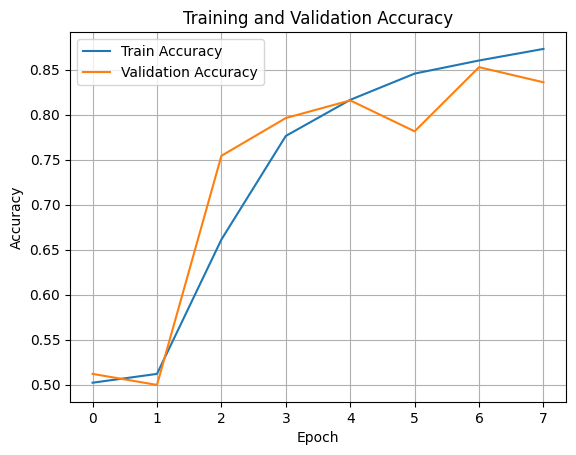

In [ ]:
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

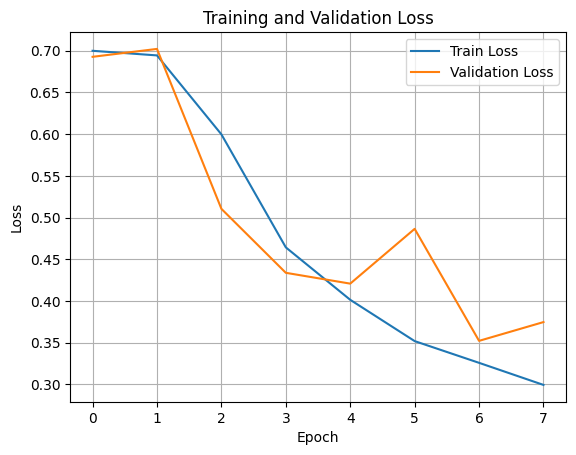

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [ ]:
model.eval()

test_loss = 0
test_acc = 0
total = 0

all_target = []
all_predicted = []

with torch.no_grad():
    for id, (feature, target) in enumerate(test_loader):
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.argmax(out, dim=1)
        correct = predicted.squeeze() == target.int()
        test_acc += correct.sum().item()
        total += correct.size(0)

        loss = criterion(out, target.cuda())
        test_loss += loss.item()

    print(f'Accuracy: {test_acc/total:.5f}, Loss: {test_loss/len(test_loader):.5f}')

Accuracy: 0.81533, Loss: 0.47045
